Reference: https://www.kaggle.com/bguberfain/naive-xgb-lb-0-317/comments/notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
import math
from sklearn.metrics import make_scorer
from sklearn.model_selection import GroupKFold
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pd.options.display.max_columns = 300
%matplotlib inline  

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df_train = pd.read_csv('train.csv', parse_dates=['timestamp'])
df_test = pd.read_csv('test.csv', parse_dates=['timestamp'])
df_macro = pd.read_csv('macro.csv', parse_dates=['timestamp'])

In [3]:
df_train.shape

(30471, 292)

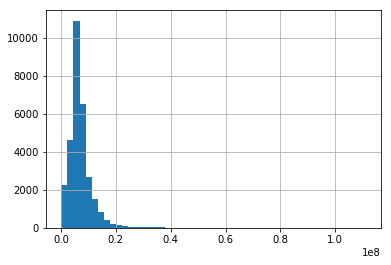

In [4]:
ax = df_train['price_doc'].hist(bins=50)

In [5]:
# y_train = df_train[['price_doc']]
# x_train = df_train.drop('price_doc', axis=1)
# We take all float/int columns except for ID, timestamp, and the target value
train_columns = list(
    set(df_train.select_dtypes(include=['float64', 'int64']).columns) - set(['id', 'timestamp', 'price_doc']))
# df_train.dropna(inplace=True)
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

y_train = df_train['price_doc']#.values
x_train = df_train[train_columns]#.values
x_test = df_test[train_columns]#.values
df_macro = df_macro[['timestamp'] + macro_cols]

In [6]:
# imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
# x_train = imp.fit_transform(x_train)
# x_test = imp.fit_transform(x_test)

In [7]:
# ylog will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog_train_all = np.log1p(df_train['price_doc'].values)
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')
print(df_all.shape)

# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp'], axis=1, inplace=True)

(38133, 303)


In [8]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [9]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
ylog_train = ylog_train_all[:-num_val]
ylog_val = ylog_train_all[-num_val:]

X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)
print('X_test shape is', X_test.shape)

(38133, 308)
('X_train_all shape is', (30471, 308))
('X_train shape is', (24377, 308))
('y_train shape is', (24377,))
('X_val shape is', (6094, 308))
('y_val shape is', (6094,))
('X_test shape is', (7662, 308))


# XGBoost

In [10]:
def rmsle(preds, labels, XGB=False):
    labels = dtrain.get_label()
    if not XGB:
#         pass
#     else:
        assert len(preds) == len(labels)
        preds = preds.tolist()

    labels = labels.tolist()
    terms_to_sum = [(math.log(labels[i] + 1) - math.log(max(0, preds[i]) + 1)) ** 2.0 for i, pred in enumerate(labels)]
    return 'rmsle', (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5

def rmsle_XGB(preds, dtrain):
    labels = dtrain.get_label()
    assert len(preds) == len(labels)
    labels = labels.tolist()
    preds = preds.tolist()
    terms_to_sum = [(math.log(labels[i] + 1) - math.log(max(0, preds[i]) + 1)) ** 2.0 for i, pred in enumerate(labels)]
    return 'rmsle', (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5

In [11]:
dtrain_all = xgb.DMatrix(X_train_all, ylog_train_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, ylog_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

In [12]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.4764
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:5.27634
[40]	val-rmse:1.99323
[60]	val-rmse:0.86519
[80]	val-rmse:0.531217
[100]	val-rmse:0.451528
[120]	val-rmse:0.431969
[140]	val-rmse:0.425149
[160]	val-rmse:0.423096
[180]	val-rmse:0.421668
[200]	val-rmse:0.421301
Stopping. Best iteration:
[195]	val-rmse:0.421207



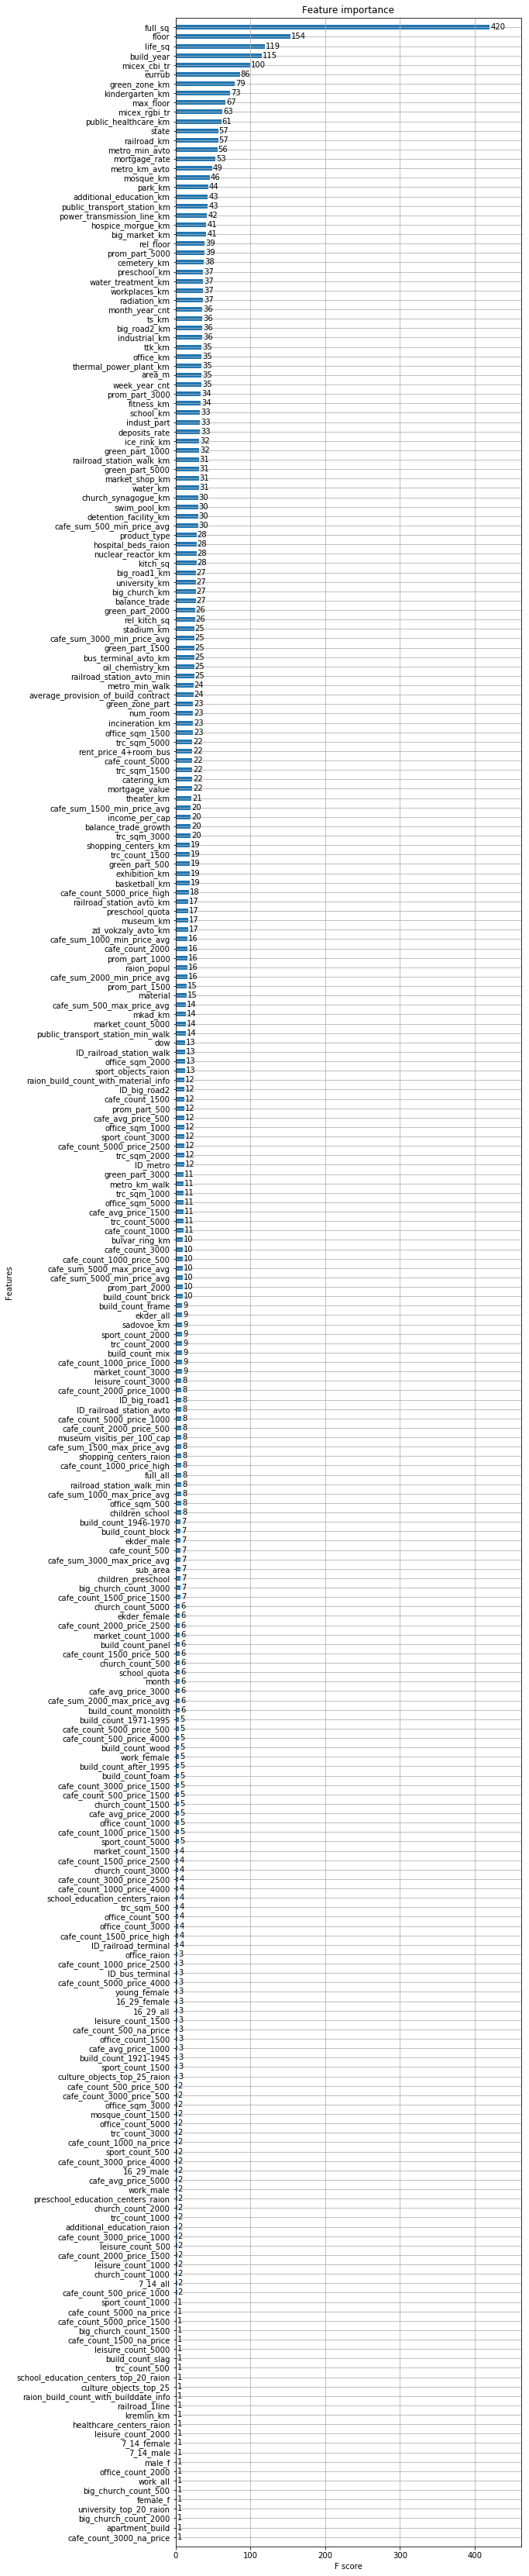

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 60))
xgb.plot_importance(partial_model, height=0.5, ax=ax)

In [20]:
num_boost_round = partial_model.best_iteration
num_boost_round

195

In [21]:
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

In [24]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('submissions/xgb2.csv', index=False)

In [19]:
p_test = clf.predict(xgb.DMatrix(x_test))

sub = pd.DataFrame()
sub['id'] = df_test['id'].values
sub['price_doc'] = p_test
sub.to_csv('submissions/xgb1.csv', index=False)

ValueError: feature_names mismatch: ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'ID_metro', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'railroad_station_avto_km', 'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road2_km', 'ID_big_road2', 'railroad_km', 'zd_vokzaly_avto_km', 'ID_railroad_terminal', 'bus_terminal_avto_km', 'ID_bus_terminal', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km', 'stadium_km', 'basketball_km', 'hospice_morgue_km', 'detention_facility_km', 'public_healthcare_km', 'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km', 'additional_education_km', 'preschool_km', 'big_church_km', 'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_count_500_na_price', 'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500', 'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000', 'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500', 'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000', 'church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000', 'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500', 'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000', 'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500', 'mosque_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500', 'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000', 'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price', 'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500', 'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high', 'big_church_count_2000', 'church_count_2000', 'mosque_count_2000', 'leisure_count_2000', 'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000', 'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000', 'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500', 'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500', 'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'big_church_count_3000', 'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000', 'market_count_3000', 'green_part_5000', 'prom_part_5000', 'office_count_5000', 'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000', 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000', 'cafe_count_5000_na_price', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000', 'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000', 'cafe_count_5000_price_high', 'big_church_count_5000', 'church_count_5000', 'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000', 'market_count_5000', 'balance_trade', 'balance_trade_growth', 'eurrub', 'average_provision_of_build_contract', 'micex_rgbi_tr', 'micex_cbi_tr', 'deposits_rate', 'mortgage_value', 'mortgage_rate', 'income_per_cap', 'rent_price_4+room_bus', 'museum_visitis_per_100_cap', 'apartment_build', 'month_year_cnt', 'week_year_cnt', 'month', 'dow', 'rel_floor', 'rel_kitch_sq', 'product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'] [u'office_sqm_1500', u'railroad_station_avto_km', u'ID_metro', u'cafe_sum_1000_max_price_avg', u'children_school', u'cafe_count_500_price_1000', u'culture_objects_top_25_raion', u'railroad_station_avto_min', u'mosque_count_500', u'trc_sqm_2000', u'cafe_count_5000_price_2500', u'trc_sqm_3000', u'office_sqm_500', u'7_14_all', u'work_all', u'build_count_brick', u'office_count_1500', u'healthcare_centers_raion', u'build_count_block', u'cafe_count_1500_price_high', u'max_floor', u'7_14_male', u'church_count_1000', u'office_count_3000', u'cafe_avg_price_3000', u'cafe_count_2000_na_price', u'market_count_500', u'trc_count_5000', u'trc_count_1000', u'catering_km', u'zd_vokzaly_avto_km', u'office_count_500', u'0_6_male', u'trc_sqm_1500', u'0_17_all', u'water_km', u'green_part_1000', u'ID_railroad_station_walk', u'big_market_km', u'cafe_count_1000', u'material', u'park_km', u'railroad_station_walk_min', u'big_road1_km', u'hospice_morgue_km', u'metro_km_avto', u'university_top_20_raion', u'preschool_quota', u'radiation_km', u'female_f', u'public_transport_station_min_walk', u'cafe_count_1000_price_1000', u'build_count_foam', u'cafe_count_3000_price_1000', u'young_male', u'ice_rink_km', u'build_count_1921-1945', u'cafe_count_500_price_500', u'ID_big_road1', u'trc_sqm_500', u'basketball_km', u'cafe_count_5000', u'school_quota', u'build_count_mix', u'school_education_centers_raion', u'cafe_avg_price_1000', u'public_healthcare_km', u'big_church_km', u'workplaces_km', u'0_13_male', u'raion_build_count_with_builddate_info', u'cafe_count_2000_price_4000', u'office_count_2000', u'area_m', u'cafe_count_1000_price_1500', u'full_all', u'cafe_count_1000_price_4000', u'cafe_count_500', u'church_count_500', u'trc_count_500', u'industrial_km', u'cafe_count_5000_price_4000', u'mkad_km', u'green_part_5000', u'0_17_male', u'cafe_sum_2000_min_price_avg', u'leisure_count_500', u'cafe_sum_500_min_price_avg', u'male_f', u'prom_part_2000', u'sport_count_3000', u'cafe_count_3000_price_2500', u'kitch_sq', u'cafe_count_3000_na_price', u'office_sqm_1000', u'full_sq', u'state', u'trc_sqm_1000', u'7_14_female', u'cafe_count_1000_price_high', u'oil_chemistry_km', u'shopping_centers_raion', u'metro_min_walk', u'leisure_count_1000', u'additional_education_raion', u'cafe_count_3000', u'16_29_female', u'cafe_sum_1500_max_price_avg', u'church_count_3000', u'ID_railroad_terminal', u'cafe_count_1500_price_2500', u'build_count_monolith', u'market_count_1500', u'cafe_avg_price_2000', u'leisure_count_2000', u'market_shop_km', u'sport_objects_raion', u'preschool_education_centers_raion', u'young_all', u'detention_facility_km', u'work_male', u'market_count_3000', u'office_raion', u'cafe_sum_5000_max_price_avg', u'cafe_count_2000_price_500', u'prom_part_5000', u'water_treatment_km', u'university_km', u'church_count_1500', u'children_preschool', u'raion_popul', u'theater_km', u'cafe_count_5000_price_1000', u'trc_count_2000', u'cafe_count_1500_price_1500', u'0_6_female', u'build_count_1946-1970', u'mosque_count_1000', u'green_zone_km', u'0_13_all', u'indust_part', u'green_part_500', u'office_sqm_2000', u'office_sqm_5000', u'build_count_after_1995', u'metro_min_avto', u'cafe_count_500_na_price', u'kremlin_km', u'prom_part_1000', u'work_female', u'railroad_km', u'cafe_count_1500', u'cafe_count_2000', u'incineration_km', u'nuclear_reactor_km', u'bus_terminal_avto_km', u'cafe_count_1500_price_1000', u'prom_part_3000', u'ID_railroad_station_avto', u'sport_count_2000', u'sadovoe_km', u'ID_big_road2', u'cafe_count_3000_price_high', u'leisure_count_1500', u'exhibition_km', u'market_count_2000', u'build_count_before_1920', u'cafe_sum_1500_min_price_avg', u'big_church_count_5000', u'cafe_sum_3000_min_price_avg', u'cafe_count_500_price_4000', u'trc_sqm_5000', u'power_transmission_line_km', u'16_29_male', u'build_year', u'hospital_beds_raion', u'0_6_all', u'stadium_km', u'green_part_2000', u'market_count_5000', u'church_count_2000', u'public_transport_station_km', u'build_count_panel', u'additional_education_km', u'bulvar_ring_km', u'kindergarten_km', u'big_church_count_3000', u'market_count_1000', u'thermal_power_plant_km', u'sport_count_1500', u'ekder_male', u'railroad_station_walk_km', u'cafe_count_2000_price_2500', u'16_29_all', u'cafe_count_2000_price_high', u'cemetery_km', u'green_zone_part', u'school_education_centers_top_20_raion', u'cafe_count_1500_price_500', u'fitness_km', u'cafe_sum_5000_min_price_avg', u'big_road2_km', u'cafe_count_3000_price_4000', u'life_sq', u'mosque_count_3000', u'young_female', u'sport_count_500', u'build_count_slag', u'cafe_count_1000_price_2500', u'cafe_count_1000_na_price', u'leisure_count_5000', u'raion_build_count_with_material_info', u'metro_km_walk', u'cafe_sum_3000_max_price_avg', u'ekder_all', u'trc_count_3000', u'office_count_1000', u'big_church_count_1000', u'cafe_count_1500_na_price', u'swim_pool_km', u'0_17_female', u'big_church_count_500', u'office_count_5000', u'cafe_count_500_price_2500', u'floor', u'prom_part_500', u'cafe_count_2000_price_1000', u'cafe_count_1000_price_500', u'cafe_count_5000_price_1500', u'school_km', u'cafe_count_500_price_1500', u'cafe_sum_500_max_price_avg', u'cafe_count_3000_price_1500', u'mosque_count_2000', u'big_church_count_1500', u'green_part_3000', u'museum_km', u'mosque_count_1500', u'ts_km', u'cafe_count_500_price_high', u'build_count_wood', u'shopping_centers_km', u'office_km', u'big_church_count_2000', u'cafe_avg_price_500', u'prom_part_1500', u'cafe_count_5000_na_price', u'preschool_km', u'cafe_sum_1000_min_price_avg', u'church_synagogue_km', u'cafe_count_1500_price_4000', u'ID_bus_terminal', u'num_room', u'sport_count_5000', u'office_sqm_3000', u'cafe_avg_price_1500', u'cafe_count_3000_price_500', u'build_count_frame', u'ttk_km', u'church_count_5000', u'cafe_count_2000_price_1500', u'green_part_1500', u'ekder_female', u'mosque_count_5000', u'leisure_count_3000', u'cafe_avg_price_5000', u'cafe_count_5000_price_high', u'cafe_count_5000_price_500', u'mosque_km', u'cafe_sum_2000_max_price_avg', u'trc_count_1500', u'0_13_female', u'sport_count_1000', u'build_count_1971-1995']
expected micex_cbi_tr, oil_chemistry_raion, ecology, sub_area, apartment_build, month, railroad_1line, mortgage_rate, rel_kitch_sq, big_road1_1line, month_year_cnt, balance_trade, incineration_raion, rel_floor, radiation_raion, week_year_cnt, railroad_terminal_raion, detention_facility_raion, deposits_rate, eurrub, big_market_raion, museum_visitis_per_100_cap, average_provision_of_build_contract, rent_price_4+room_bus, culture_objects_top_25, product_type, micex_rgbi_tr, thermal_power_plant_raion, dow, mortgage_value, balance_trade_growth, water_1line, nuclear_reactor_raion, income_per_cap in input data